# Imports

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation
from spellchecker import SpellChecker
# nltk.download('all')

In [2]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Functions

### 1. Data cleaning

In [4]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
    
    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def tokenization(text):
    tokens  = word_tokenize(text)

    return ' '.join(tokens)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
    

def lem_text(text):
    doc = nlp(text)
    lemma = ' '.join([token.lemma_ for token in doc])
    
    return lemma

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '')

    return replaced

def spell_correct(text):
    if text is None or not isinstance(text, str):
        return text

    spell = SpellChecker()

    # Find misspelled words
    misspelled = spell.unknown(text.split())

    # Correct misspelled words
    corrected_text = [spell.correction(word) if word in misspelled else word for word in text.split()]
    
    try:
        return ' '.join(corrected_text)
    except:
        return ' '.join(text)



### 2. Merge cleaning functions for one function

In [5]:
def preprocessing_data(text):
    
    text = remove_special_characters(text) #pass
    text = remove_punctuation(text) #pass
    text = convert_to_lowercase(text) #pass
    text = tokenization(text) #pass
    text = remove_stopwords(text) #pass
    text = lem_text(text) #pass
    text = replace(text) #pass
    return text

### 3. Restore basic forms of words

In [6]:
def lemmatization(text):
    doc = nlp(text)
    lem_tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    return ' '.join(lem_tokens)
    
    # return lem_text

def stemming(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

    # return stem_text

def remove_POS_tags(text):
    doc = nlp(text)
    result = [token.text for token in doc if token.tag_ == 'NN']  # check for nouns
    return ' '.join(result)
    # return remove_pos


#Write your function to extract the POS tags NN
# def extract_pos_tags(text):
#     doc = nlp(text)
#     sent = [token.text for token in doc if token.tag_ == 'NN']
#     return ' '.join(sent)

# finding ngrams

In [7]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [8]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [9]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [10]:

data = df # replace to have possibility to load back original data
data['clean'] = data['complaint_text'].apply(lambda x: preprocessing_data(x)) # new column with preprocessed data
data['clean'] = data['clean'].apply(lambda x: lemmatization(x))
data['clean'] = data['clean'].apply(lambda x: remove_POS_tags(x))
data.head()

,complaint_text,category,clean
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account money s...


### Check data

(array([9.072e+03, 6.363e+03, 2.798e+03, 1.269e+03, 8.000e+02, 3.080e+02,
        1.470e+02, 8.400e+01, 6.100e+01, 3.800e+01, 3.700e+01, 1.600e+01,
        1.400e+01, 1.300e+01, 7.000e+00, 8.000e+00, 6.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 8.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.  ,   247.14,   494.28,   741.42,   988.56,  1235.7 ,
         1482.84,  1729.98,  1977.12,  2224.26,  2471.4 ,  2718.54,
         2965.68,  3212.82,  3459.96,  3707.1 ,  3954.24,  4201.38,
         4448.52,  4695.66,  4942.8 ,  5189.94,  5437.08,  5684.22,
         5931.36,  6178.5 ,  6425.64,  6672.78,  6919.92,  7167.06,
         7414.2 ,  7661.34,  7908.48

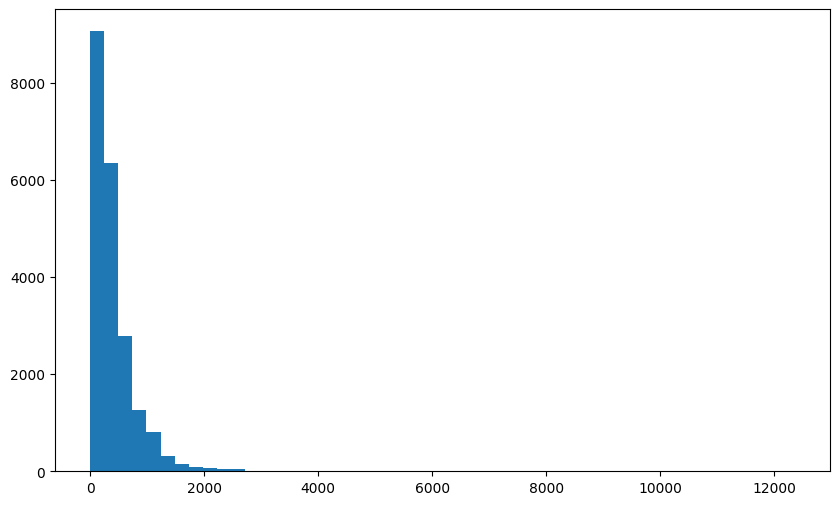

In [11]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data.clean]
doc_lens = [len(d) for d in data.clean]
plt.hist(doc_lens, bins = 50)

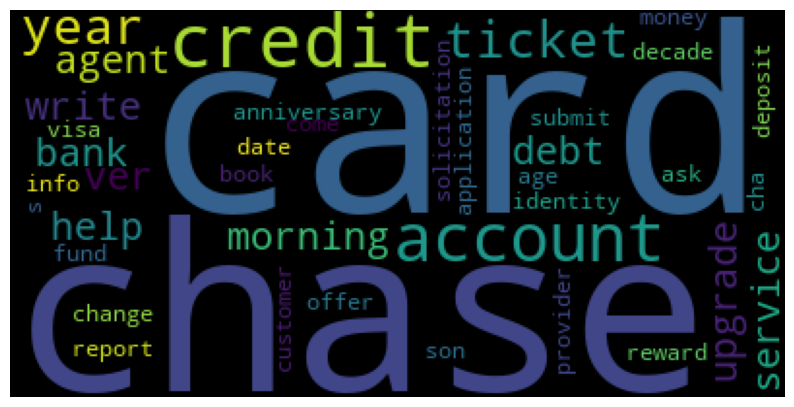

In [12]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [13]:
data.head(20)

,complaint_text,category,clean
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account money s...
15,Can you please remove inquiry,"Credit reporting, credit repair services, or o...",inquiry
17,With out notice J.P. Morgan Chase restricted m...,Checking or savings account+Checking account,account debit card branch customer service rep...
20,"During the summer months, I experience a decli...",Vehicle loan or lease+Loan,summer month experience income employment requ...
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","Money transfer, virtual currency, or money ser...",payment retailer chase pay chase website scam ...
23,I have a Chase credit card which is incorrectl...,Credit card or prepaid card+General-purpose cr...,chase credit card datum credit report company ...


# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

##### vectorizer - TFIDF

In [14]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
# vectorizer.get_feature_names_out()[:10]

In [15]:
dtm

<21072x6906 sparse matrix of type '<class 'numpy.float64'>'
	with 683659 stored elements in Compressed Sparse Row format>

### Finding top n-grams

In [16]:
top_unigrams = get_top_ngrams(data['clean'], 1)
top_bigrams = get_top_ngrams(data['clean'], 2)
top_trigrams = get_top_ngrams(data['clean'], 3)

In [17]:
top_unigrams[:5]

[(('chase',), 59632),
 (('account',), 43422),
 (('credit',), 33888),
 (('card',), 30227),
 (('payment',), 21160)]

In [18]:
top_bigrams[:5]

[(('credit', 'card'), 12839),
 (('credit', 'report'), 3980),
 (('chase', 'credit'), 3425),
 (('check', 'account'), 3216),
 (('customer', 'service'), 2991)]

In [19]:
top_trigrams[:5]

[(('chase', 'credit', 'card'), 2462),
 (('credit', 'card', 'account'), 1063),
 (('credit', 'card', 'company'), 983),
 (('credit', 'card', 'chase'), 825),
 (('chase', 'customer', 'service'), 566)]

### Vectorizer - TF-IDF

In [20]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
feature_names = np.array(vectorizer.get_feature_names_out())

### NFM

In [49]:
model = NMF(n_components=5, random_state=40)
W = model.fit_transform(dtm)
H = model.n_components_

In [34]:
categories = []
for i, document in enumerate(dtm):
    assigned_cat = W[i].argmax()
    categories.append(assigned_cat)
    
data["new_cat"] = categories

In [52]:
num_words = 15
for topic_idx, topic in enumerate(model.components_):
    print(f"Topic #{topic_idx + 1}:")
    top_words_idx = topic.argsort()[:-num_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(" ".join(top_words))
    print()

Topic #1:
account check bank money deposit chase fund branch day transfer transaction number business claim customer

Topic #2:
card charge chase credit dispute fee purchase transaction service merchant use fraud balance time refund

Topic #3:
loan mortgage chase home modification property year letter document time rate request foreclosure sale refinance

Topic #4:
credit report inquiry card account score company debt reporting information chase remove identity application limit

Topic #5:
payment balance pay month fee statement day time chase auto date credit account year mortgage



In [57]:


#Create the dictionary of Topic names and Topics
cat_mapping = {
    0: 'Account services',
    1: 'card services',
    2: 'Mortgage/Loan services',
    3: 'Reporting services',
    4: 'Others services'
}

#Replace Topics with Topic Names
data['new_cat'] = data['new_cat'].map(cat_mapping)



In [58]:
temp =data[['complaint_text','clean','category','new_cat']].groupby('new_cat').head(10)
temp.sort_values('new_cat')

,complaint_text,clean,category,new_cat
27,I opened an account with chase bank on XXXX an...,account bank code bonus follow term tell accou...,Checking or savings account+Checking account,Account services
92,"In XX/XX/2019, several transactions on my Chas...",transaction chase check account file report ch...,Debt collection+I do not know,Account services
42,My card went missing and i didnt realize it un...,card today email deposit bank account,Checking or savings account+Checking account,Account services
101,I Purchase is an airline ticket on XX/XX/XXXX ...,airline ticket dollar airport ticket hour post...,Checking or savings account+Checking account,Account services
35,I opened the saving account for the {$25.00} b...,bonus auto transfer check saving notice transf...,Checking or savings account+Savings account,Account services
103,On XX/XX/XXXX I received an advertisement via ...,advertisement email chase customer chase check...,Checking or savings account+Checking account,Account services
24,mishandling of this account by Chase auto and ...,mishandle account chase auto,Vehicle loan or lease+Loan,Account services
69,Someone called stating I had felony committed ...,state felony security number account asset sta...,Checking or savings account+Checking account,Account services
17,With out notice J.P. Morgan Chase restricted m...,account debit card branch customer service rep...,Checking or savings account+Checking account,Account services
14,my grand son give me check for {$1600.00} i de...,son deposit chase account fund account money s...,Checking or savings account+Checking account,Account services


# LDA